In [7]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import sys

In [8]:
sys.path.insert(0, '..')

In [9]:
from convlstm_classes import ConvLSTM

Below, dataset is the original dataset, with non-normalized features and containing nan values. dataset_norm has the features normalized and nan values replaced by 0.

In [10]:
dataset = torch.tensor(np.load('../../../numpy_dataset/dataset.npy'))

In [11]:
dataset_norm = torch.tensor(np.load('../../../numpy_dataset/dataset_normalized.npy'))

The input X consists of the first 11 days of data (the current day preceded by 10 days of lag). The target y consists of the rest of the data (30 days of lead).

In [12]:
X = dataset_norm[:,:11,:,:,:]

In [13]:
y = dataset_norm[:,11:,:,:,:]

y_un is pulled from dataset and thus contains nan values.

In [14]:
y_un = dataset[:,11:,:,:,:]

In [15]:
future_steps = 30

In [20]:
model = ConvLSTM(input_dim=8, hidden_dim=8, kernel_size=(3,3), num_layers=3,
                 batch_first=True, bias=True, return_all_layers=True, dropout_prob=0.3,
                 output_size=30, output_channel=1)

In [21]:
model.load_state_dict(torch.load('../best_model_params.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [22]:
model.eval()

ConvLSTM(
  (cell_list): ModuleList(
    (0-2): 3 x ConvLSTMCell(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (batchnorm_list1): ModuleList(
    (0-2): 3 x BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout_list1): ModuleList(
    (0-2): 3 x Dropout(p=0.3, inplace=False)
  )
  (batchnorm_list2): ModuleList(
    (0-2): 3 x BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout_list2): ModuleList(
    (0-2): 3 x Dropout(p=0.3, inplace=False)
  )
)

In [23]:
test_len = int(len(X) * 0.2)

In [24]:
the_range = list(range(len(X) - test_len, len(X)))

We'll take 20 random samples from the test set and graph the predictions of the model on those 20 random samples.

In [25]:
np.random.seed(42)

In [26]:
sample_indices = np.random.choice(the_range, size=20, replace=False)

In [27]:
sample_indices

array([809, 760, 782, 706, 745, 680, 752, 702, 751, 795, 670, 735, 666,
       717, 675, 681, 794, 755, 749, 667])

In [28]:
sample = X[sample_indices,:,:,:,:]

In [29]:
y_pred = model(sample).squeeze(2).detach().numpy()

In [30]:
y_pred.shape

(20, 30, 10, 20)

In [31]:
y_true = y[sample_indices,:,1,:,:].numpy()

In [32]:
y_true.shape

(20, 30, 10, 20)

Below, we mask y_pred and y_true using the nan values in y_un in order to display the predictions sensibly in a pdf.

In [33]:
for_mask = y_un[sample_indices,:,1,:,:]

In [34]:
y_pred = np.ma.masked_where(for_mask.isnan(), y_pred)

In [35]:
y_true = np.ma.masked_where(for_mask.isnan(), y_true)

In [36]:
cmap = plt.get_cmap('Blues')

In [37]:
cmap.set_bad(color='green')

Here we graph the predictions of the model on each of the 20 random test samples. 

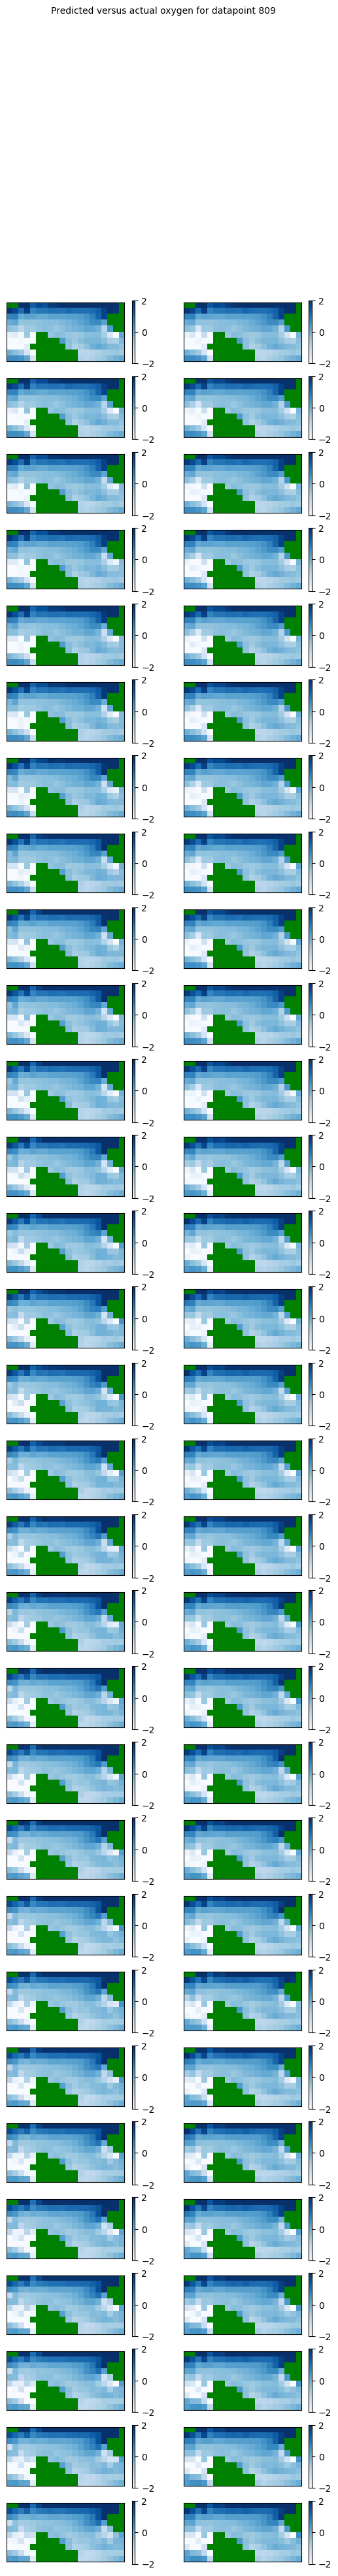

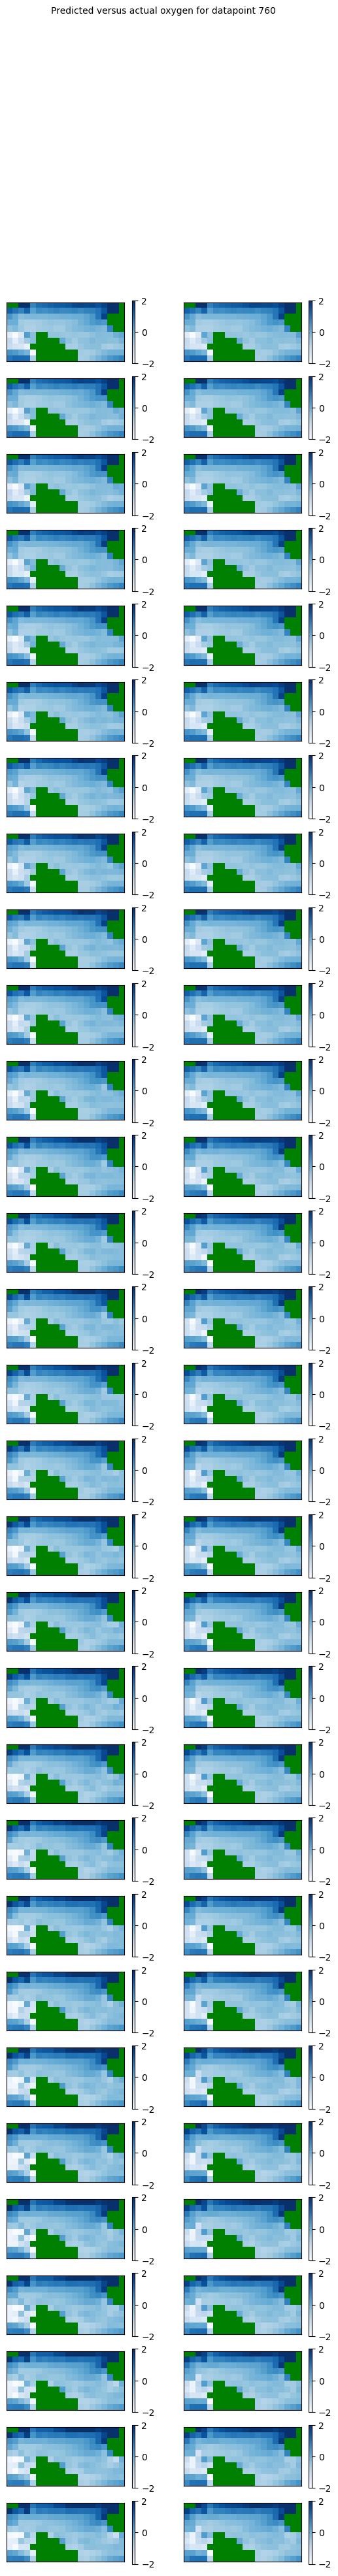

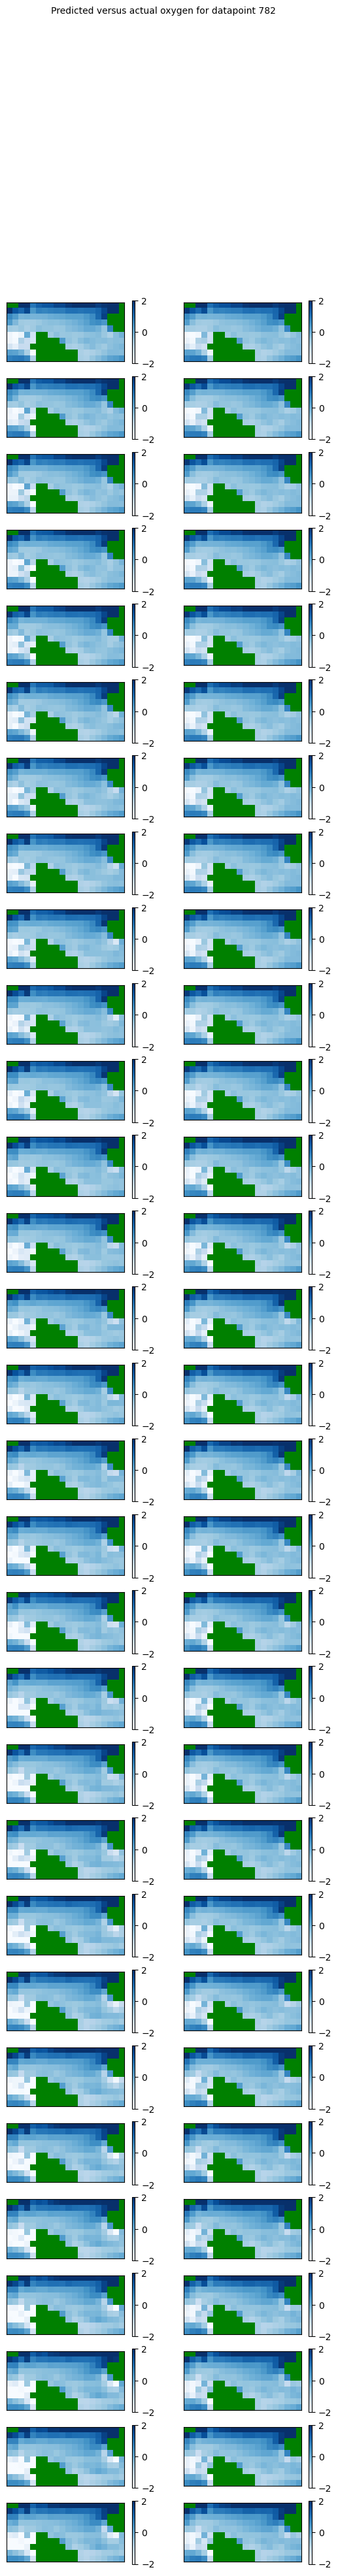

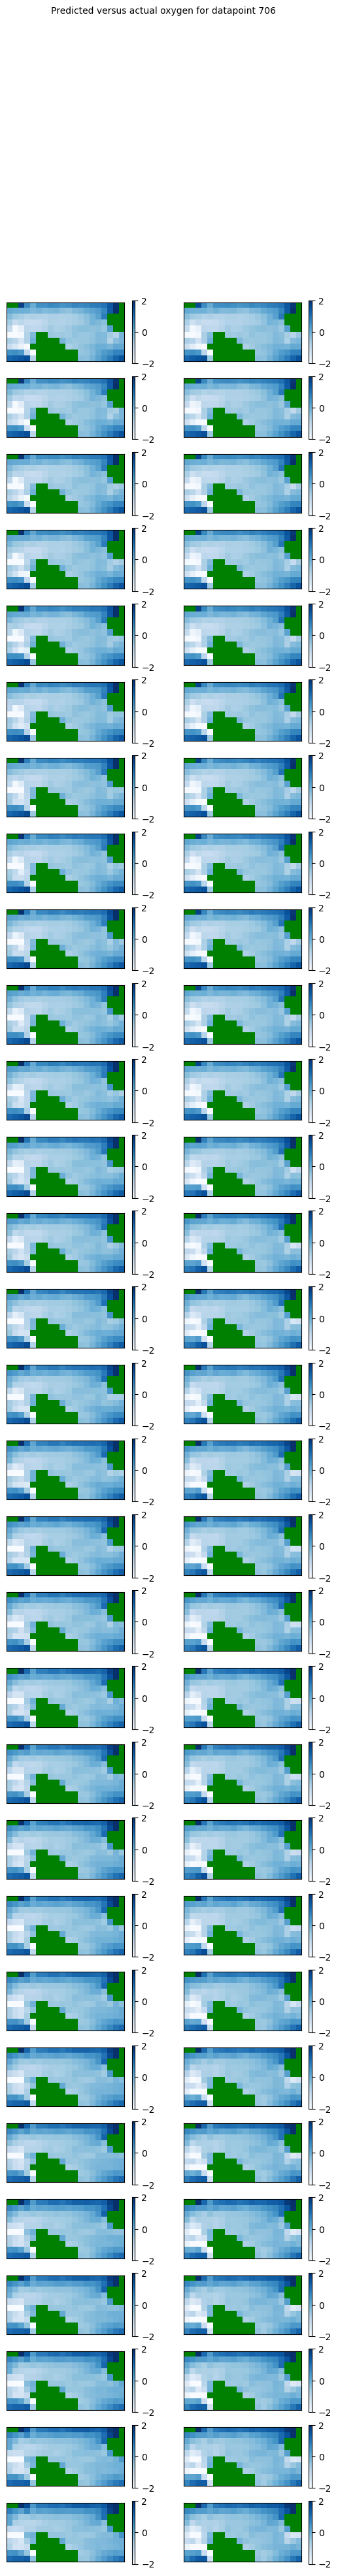

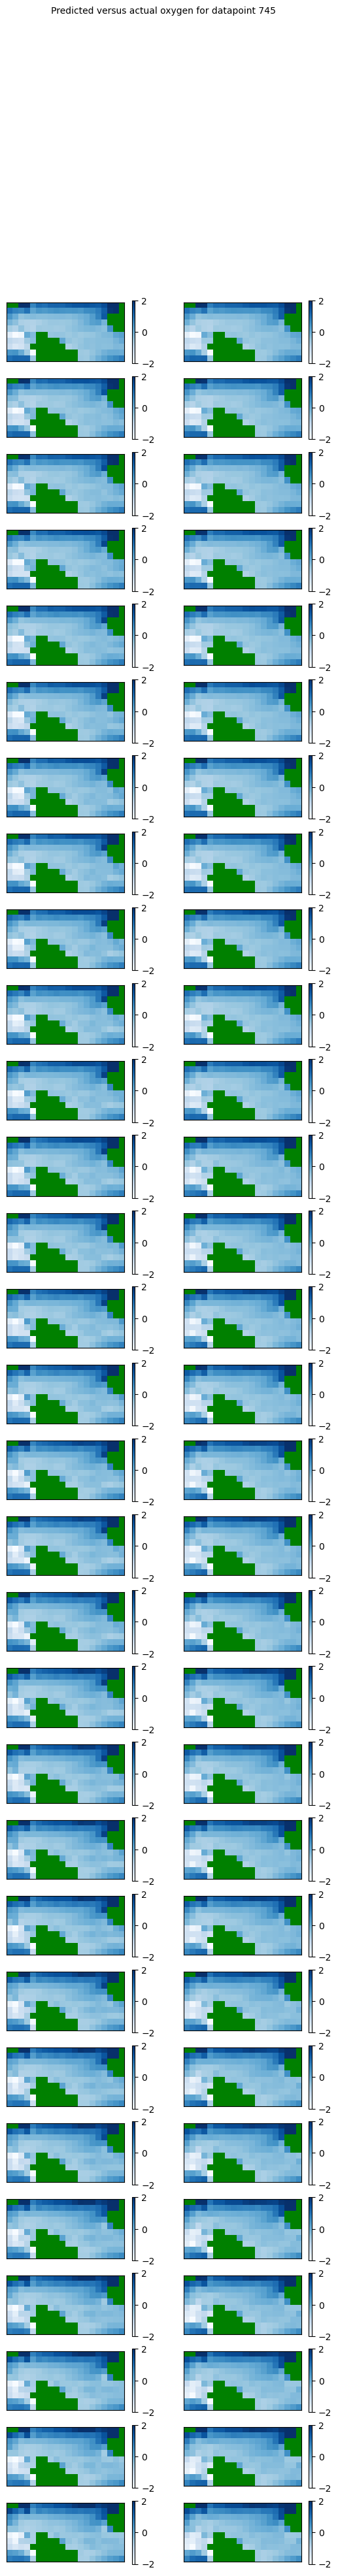

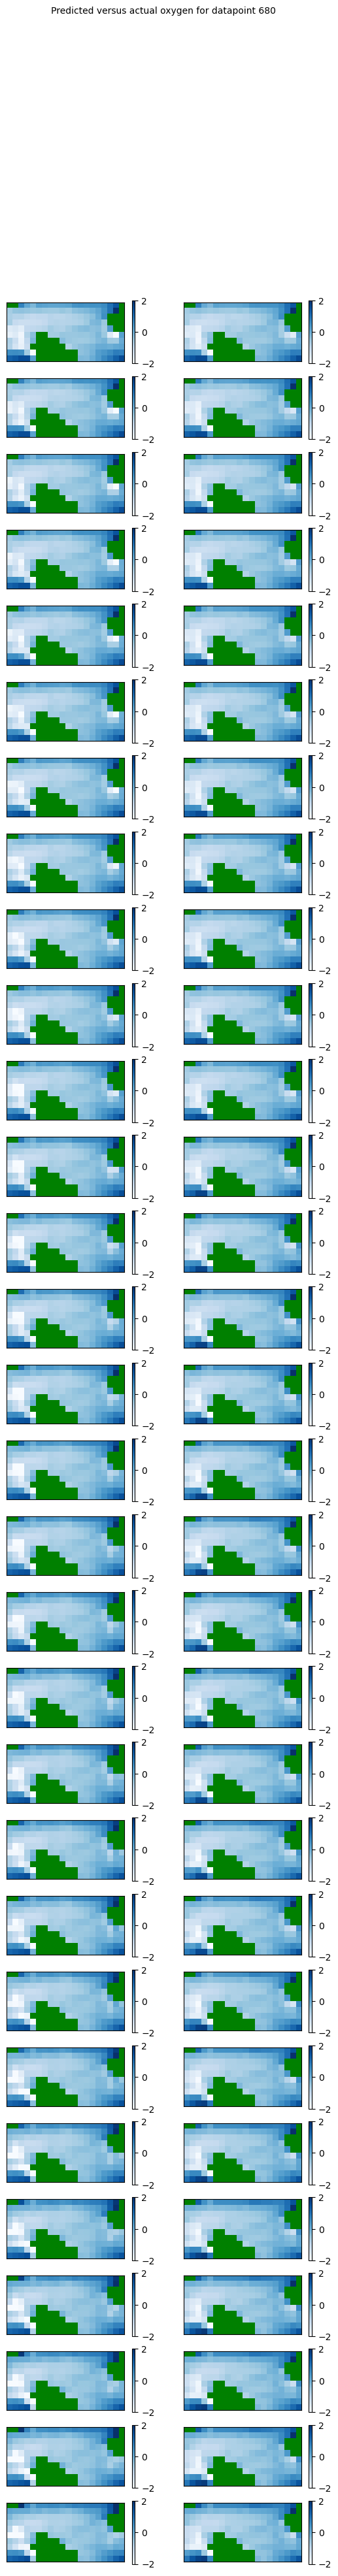

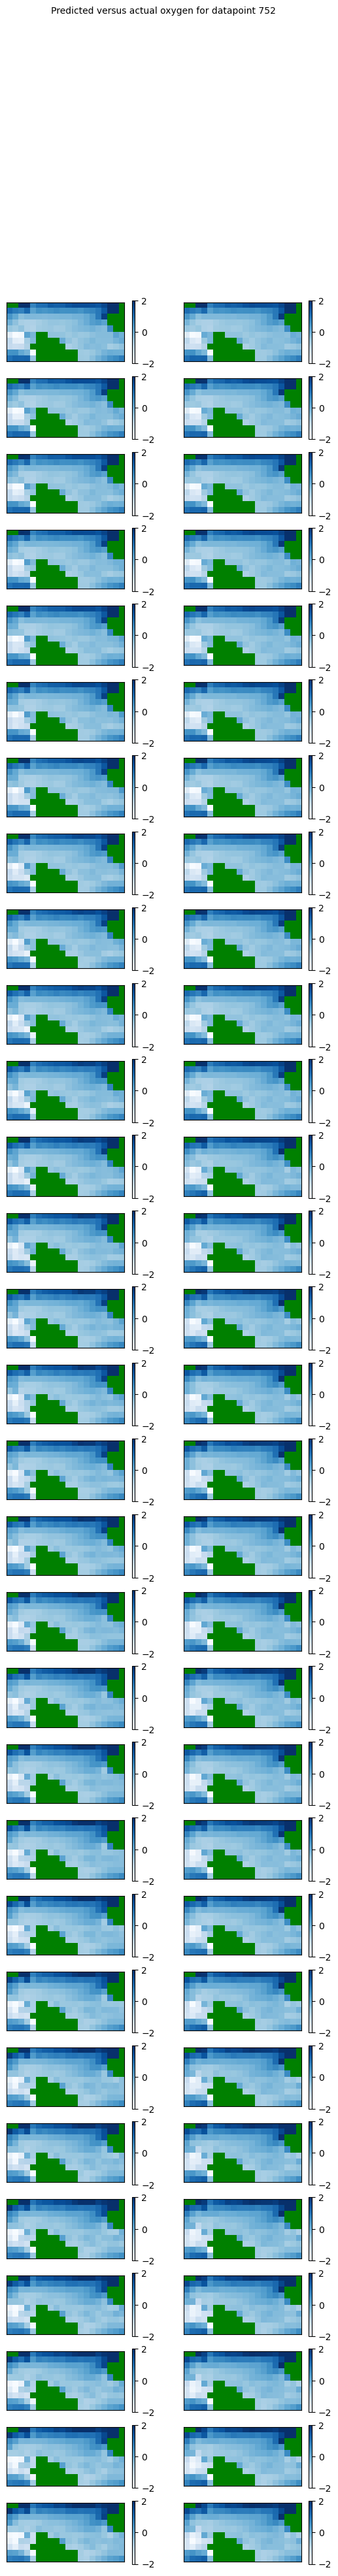

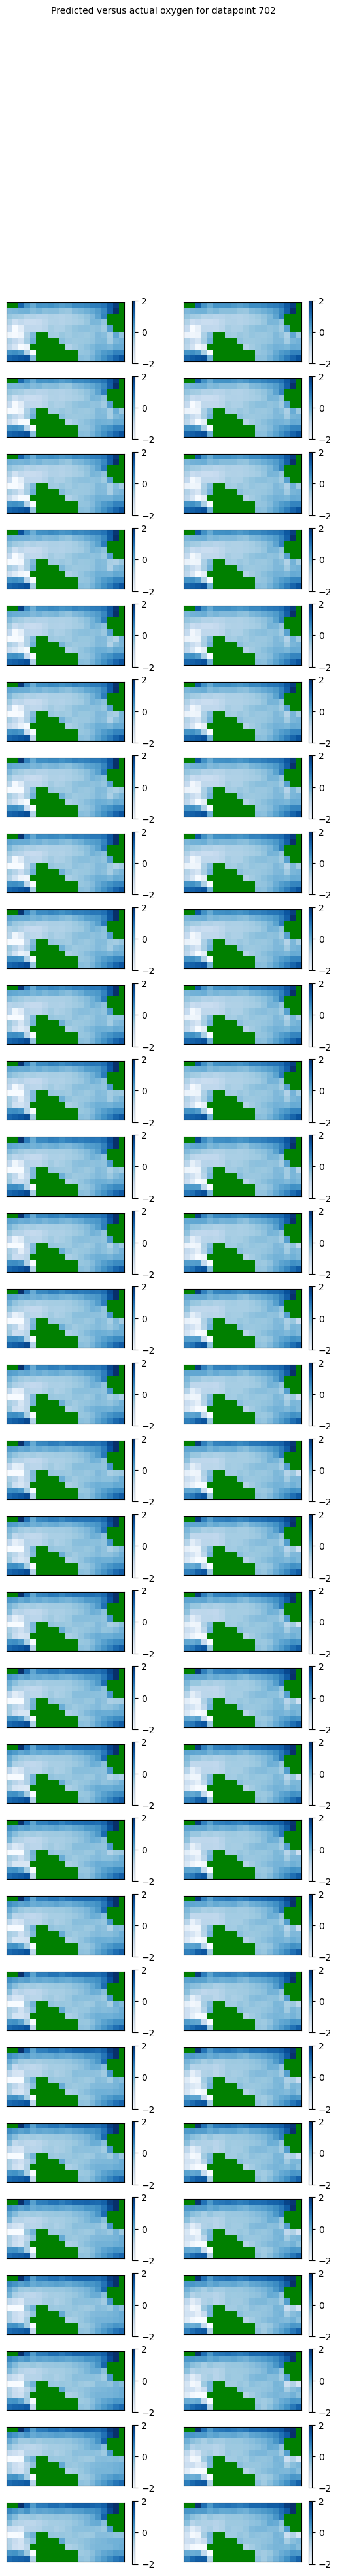

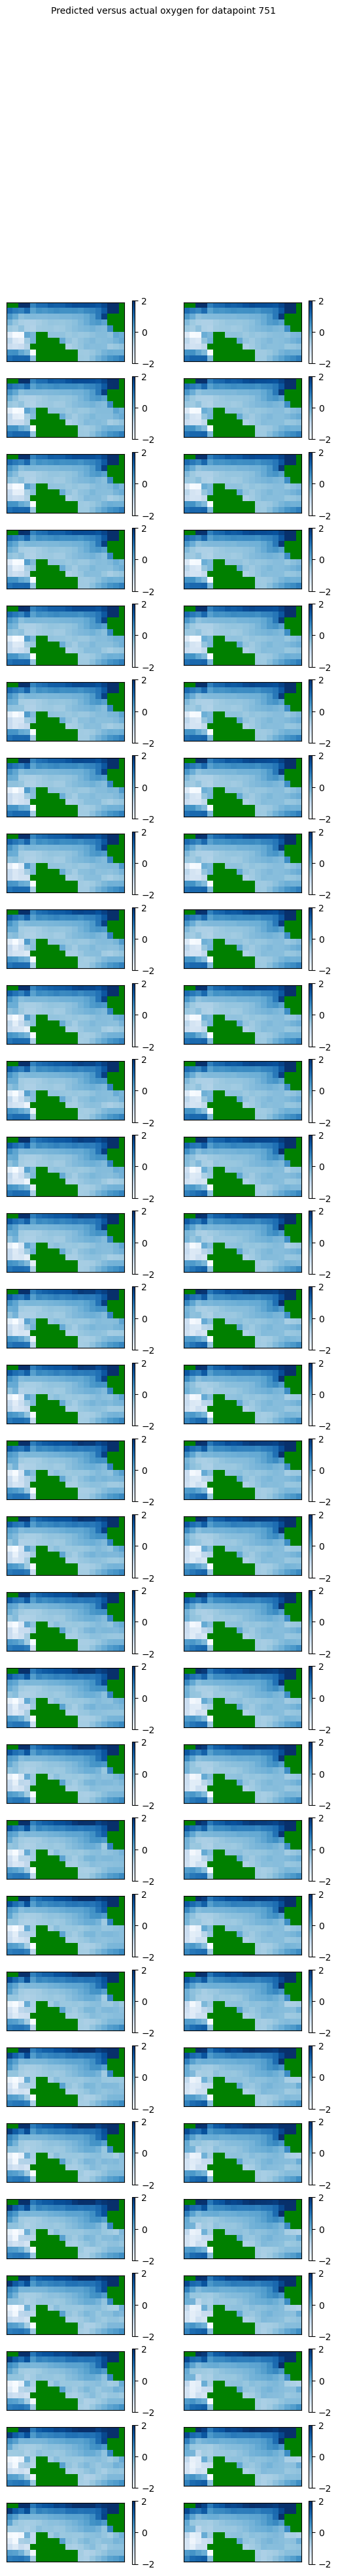

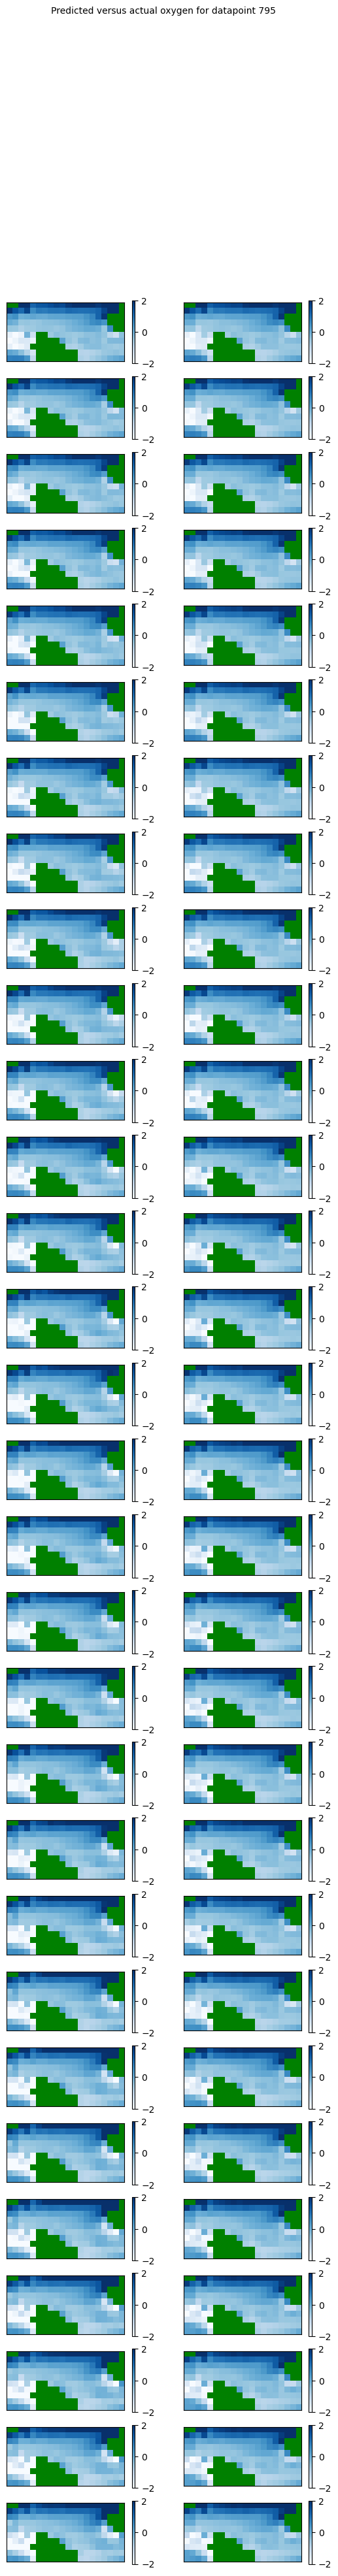

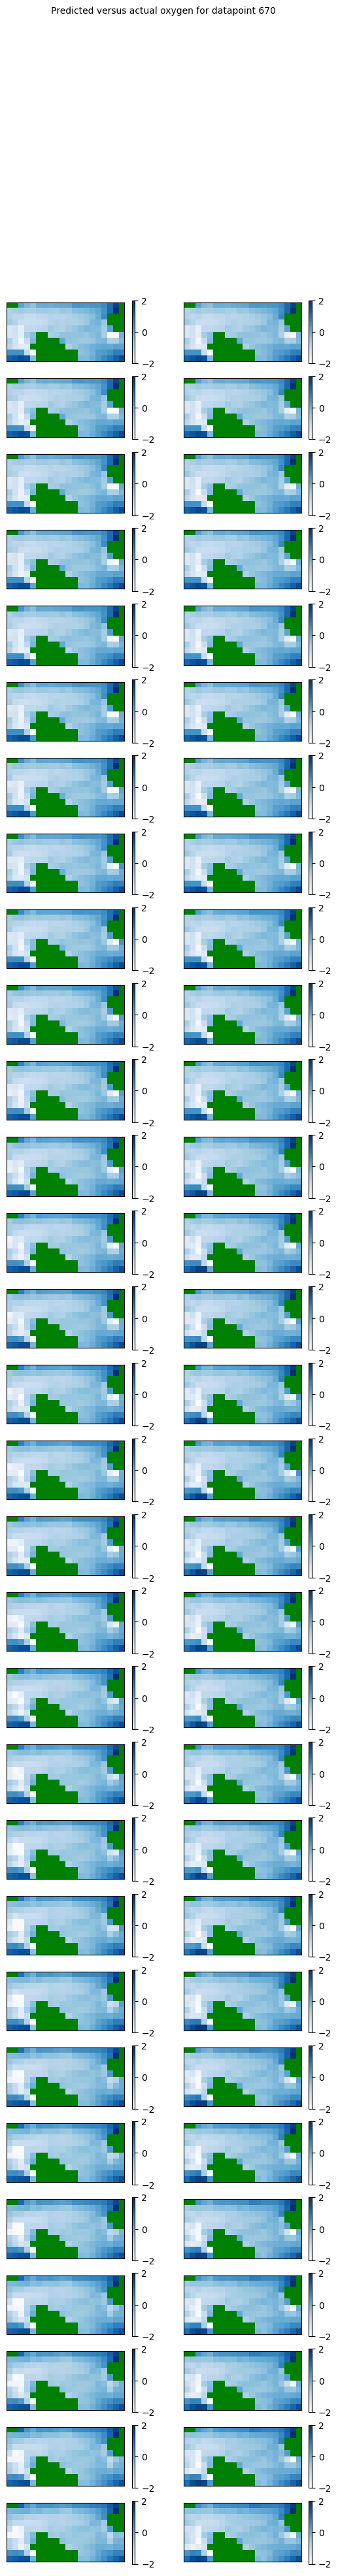

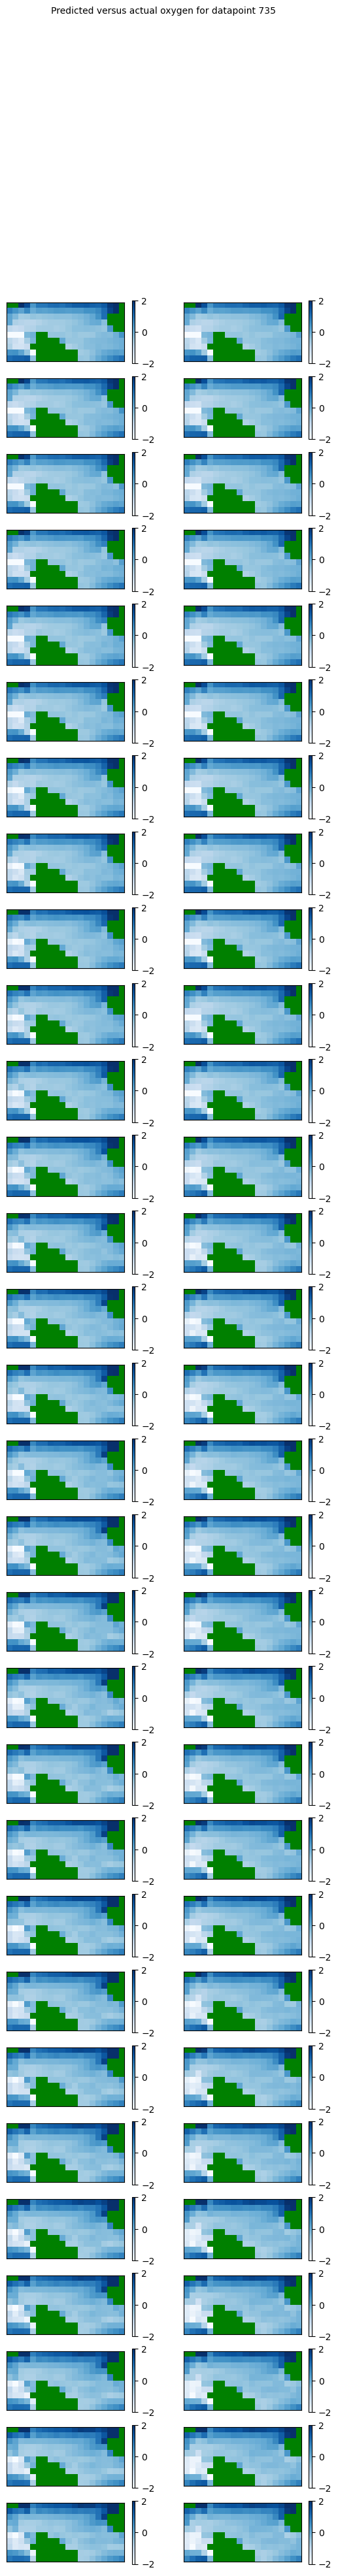

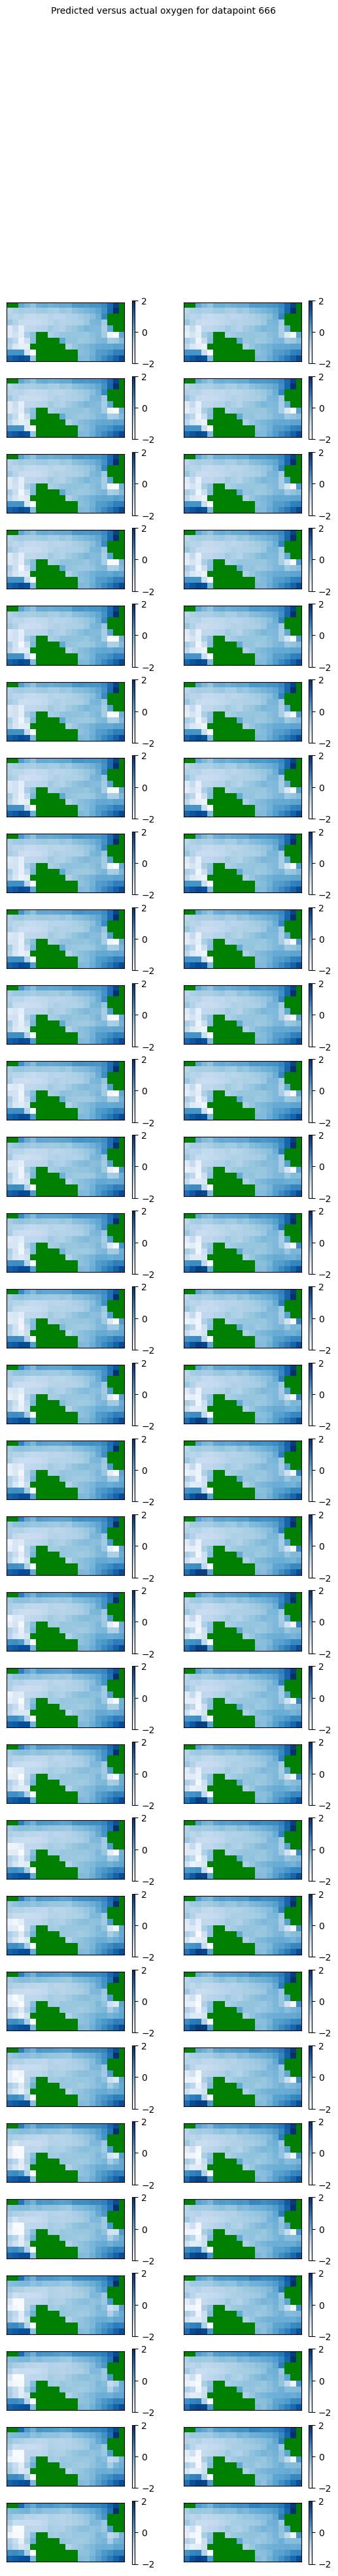

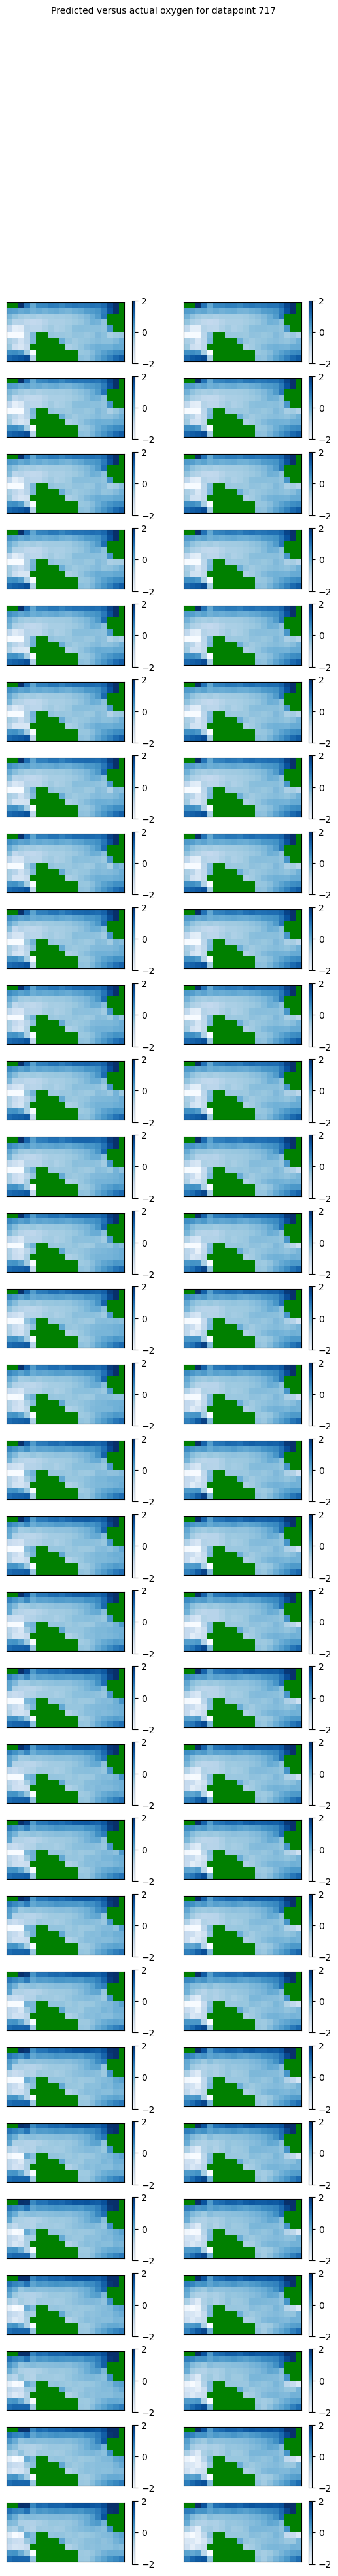

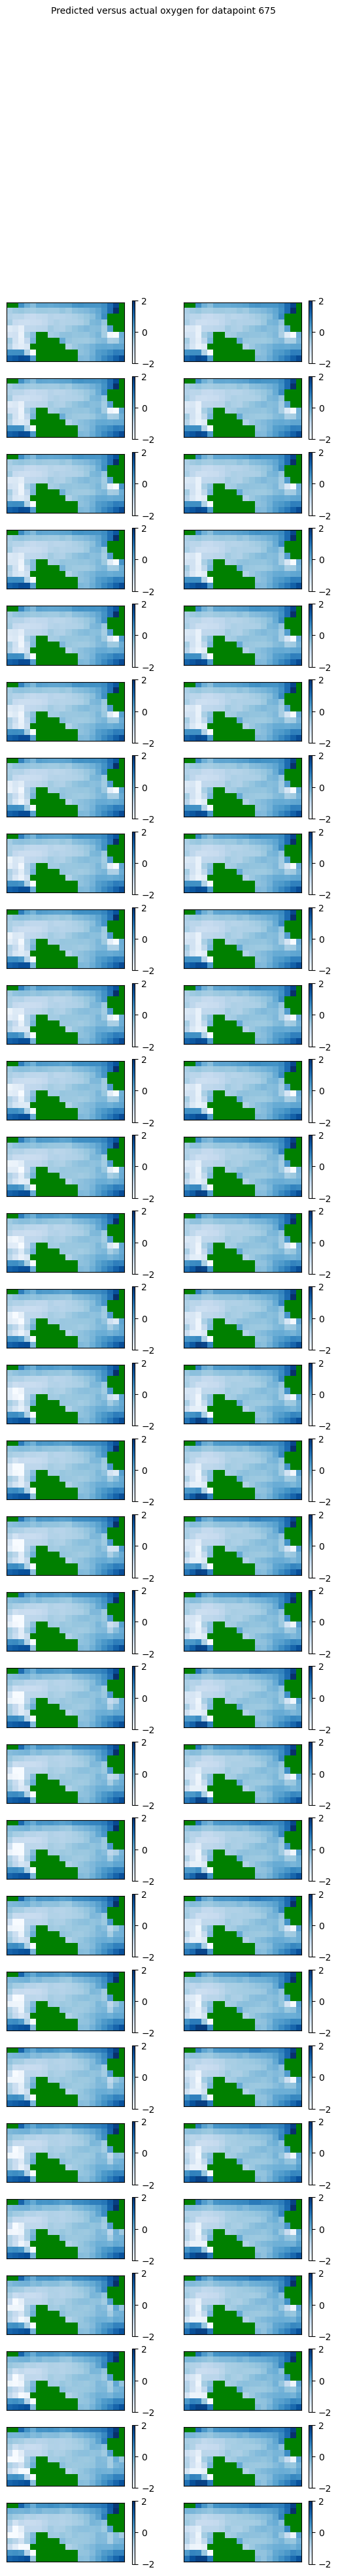

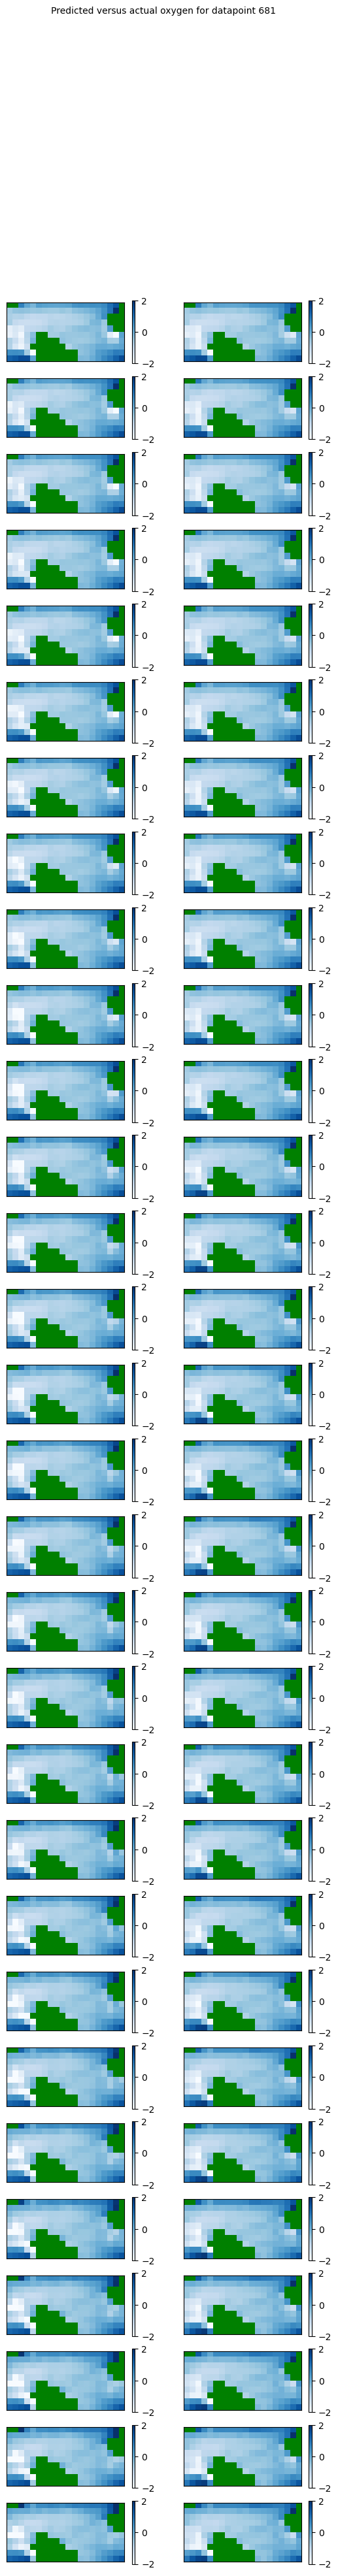

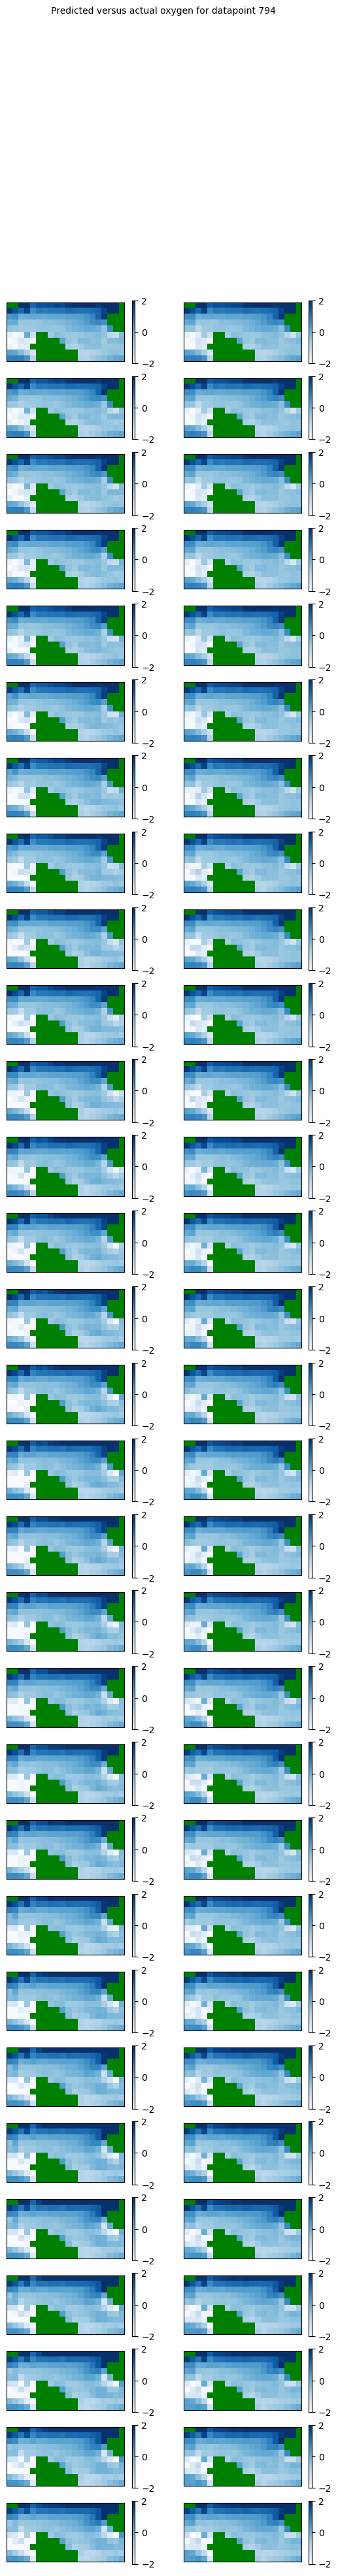

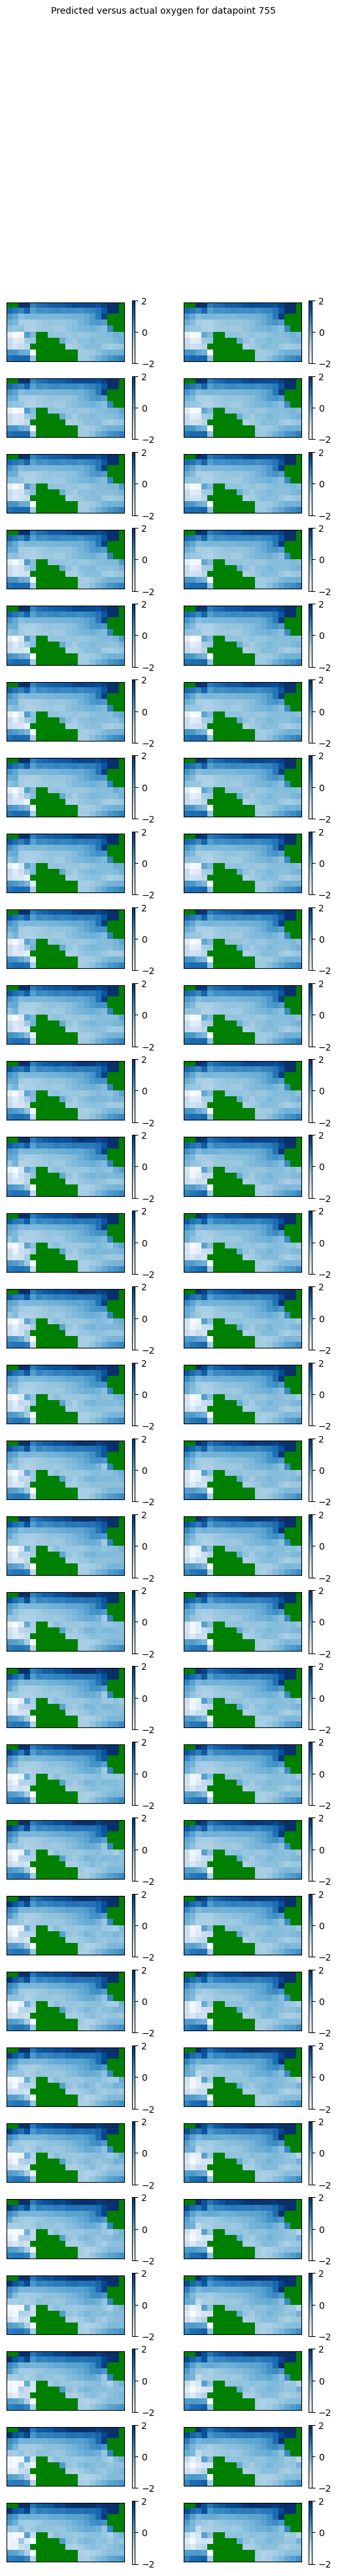

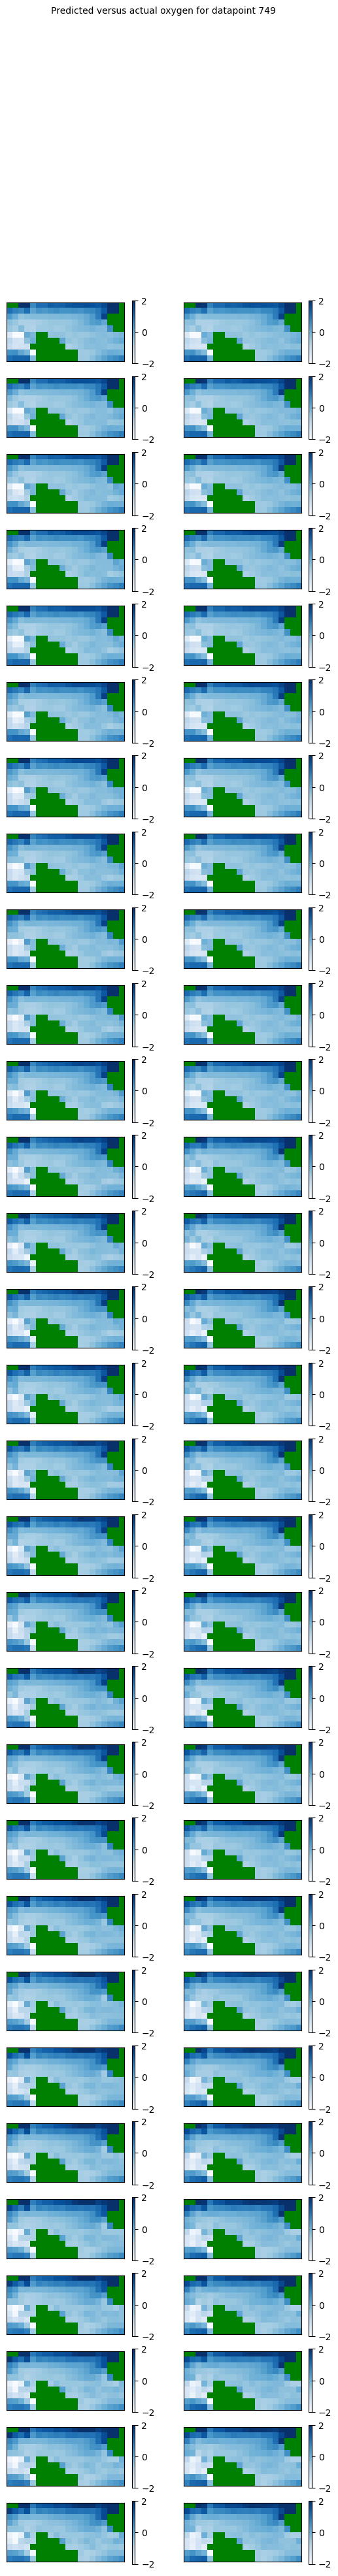

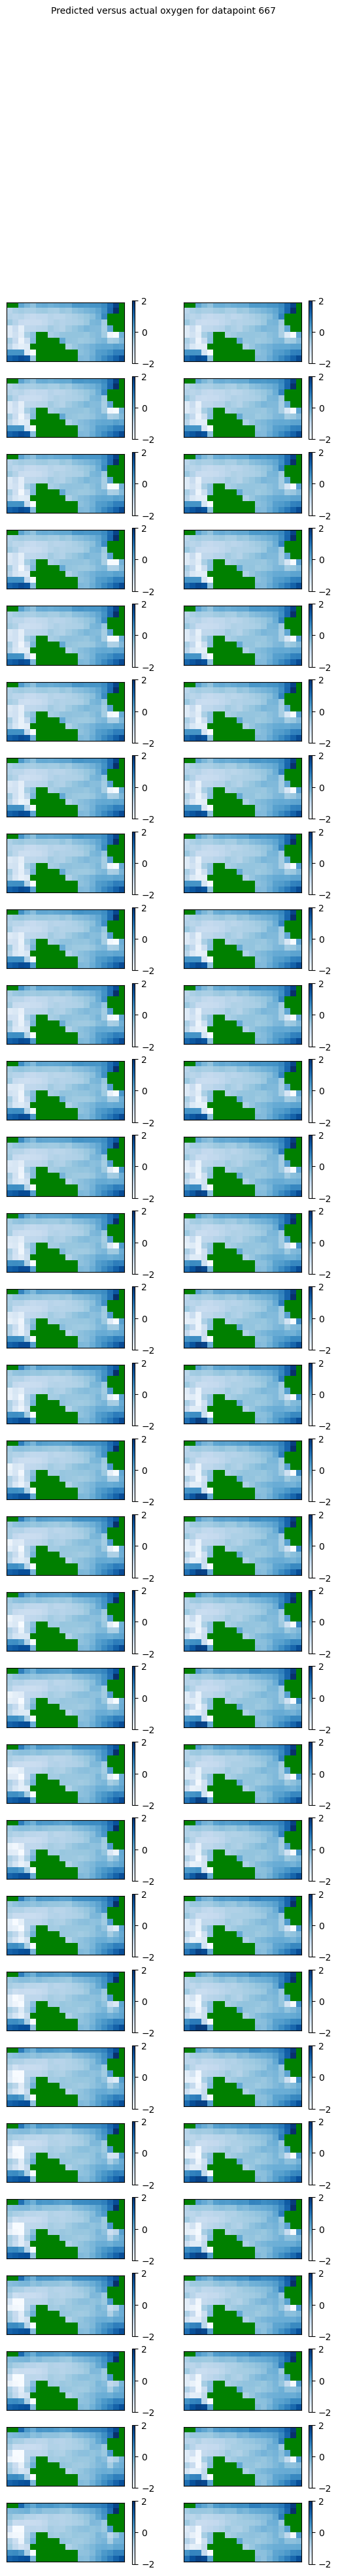

In [38]:
for i, ind in enumerate(sample_indices):
    y_pred_ = y_pred[i]
    y_true_ = y_true[i]

    fig, axes = plt.subplots(30,2)

    fig.set_figheight(45)
    
    fig.suptitle(f'Predicted versus actual oxygen for datapoint {ind}', fontsize=10)
    
    for j in range(30):
        axs = axes[j]
        axs[0].get_xaxis().set_ticks([])
        axs[0].get_yaxis().set_ticks([])
        axs[1].get_xaxis().set_ticks([])
        axs[1].get_yaxis().set_ticks([])
        t = axs[0].imshow(y_true_[j], cmap=cmap, vmin=-2, vmax=2, origin='lower')
        p = axs[1].imshow(y_pred_[j], cmap=cmap, vmin=-2, vmax=2, origin='lower')
        fig.colorbar(t, ax=axs[0], location='right')
        fig.colorbar(p, ax=axs[1], location='right')
    
    plt.savefig(f'graph_point_{ind}.pdf', format='pdf')
    plt.show()